In [38]:
import radd
from radd import vis, build
from scipy import optimize
import scipy.stats as stats
csv=pd.read_csv
from scipy.stats import ttest_rel
os.chdir("/Users/kyle/Desktop/")
labels=['Baseline', 'Caution']
colors=['#2d2d2d','#6a6a6a']
out="/Users/kyle/Desktop/"

# All data DF, BSL Data, PNL Data (Unfiltered)

In [29]:
#pro_all=final.all_data('pro')
bsl=prodf.query('Cond=="bsl"')
pnl=prodf.query('Cond=="pnl"')

## P(Stop)

In [30]:
bsl_pstop_idx=1-bsl.pivot_table('response', 'idx', 'pGo')
pnl_pstop_idx=1-pnl.pivot_table('response', 'idx', 'pGo')

bsl_pstop=bsl_pstop_idx.mean()
pnl_pstop=pnl_pstop_idx.mean()

bsl_pstop_err=bsl_pstop_idx.sem()*1.96
pnl_pstop_err=pnl_pstop_idx.sem()*1.96

In [12]:
bsl_pstop

pGo
0.0    0.9443
0.2    0.7803
0.4    0.5500
0.6    0.3418
0.8    0.1189
1.0    0.0854
dtype: float64

In [13]:
prodf.to_csv("../Dropbox/pro555.csv", index=False)

In [8]:
godf = pro[pro.response==1].copy()
godf['response']=np.where(godf.rt<.555, 1, 0)
prodf = pd.concat([godf, pro[pro.response==0]])

In [24]:
def scurves(lines=[], task='ssRe', linestyles=[], pstop=.5, sxdata=None, pse_only=False, labels=[], colors=[], yerr=[], all_solid=False, title='stop_curves', plot_data=False):

      if len(lines[0])==6:
                task='pro'
      if linestyles==[]:
                linestyles=['-']*len(lines)
      sns.set(style='ticks', context='paper')
      #sns.set_style(rc=style_params['style'])
      #sns.set_context(rc=style_params['context'])
      sns.set_context(rc={'lines.markeredgewidth': 0.1})

      lines=[np.array(line) if type(line)==list else line for line in lines]

      if colors==[]:
            colors=sns.color_palette(sns.color_palette(),len(lines))
      if labels==[]:
            labels=["C%i"%i for i in np.arange(len(lines))]

      f, ax = plt.subplots(1, figsize=(6., 6.5))
      pse=[]; xsim=np.linspace(-5, 110, 10000)

      if 'Re' in task:
            x=np.array([400, 350, 300, 250, 200], dtype='float')
            xsim=np.linspace(15, 50, 10000)
            scale_factor=100
            xxlim=(17, 42)
            xxlabel='SSD (ms)'
            xxticks=np.arange(20, 45, 5)
            xxticklabels=np.arange(200, 450, 50)
            yylabel="P(Stop)"
            c=colors; ms=4.5
      else:
            x=np.array([100, 80, 60, 40, 20, 0], dtype='float')
            xxticks=np.arange(0, 12, 2)#x/scale_factor
            xxticklabels=np.arange(0.0, 1.2, .20)
            xxlim=(-1, 11)
            xxlabel='P(Go)'
            xsim=np.linspace(-5, 11, 10000)
            scale_factor=10
            yylabel="P(NoGo)"
            c=["#545454","#545454"]; ms=4.5

      if all_solid or pse_only:
            linestyles=['-']*len(lines)

      x=analyze.res(-x,lower=x[-1]/10, upper=x[0]/10)

      for i, yi in enumerate(lines):

            y=analyze.res(yi, lower=yi[-1], upper=yi[0])
            p_guess=(np.mean(x),np.mean(y),.7,.7)
            p, cov, infodict, mesg, ier = optimize.leastsq(
                analyze.residuals,p_guess,args=(x,y), full_output=1, maxfev=5000, ftol=1.e-10)
            x0,y0,c,k=p
            xp = xsim
            pxp=analyze.sigmoid(p,xp)
            idx = (np.abs(pxp - pstop)).argmin()

              #use fitted values to initiate and refit for better accuracy
            next_guess=(np.mean(xsim), xp[idx], .75, 1.)
            p, cov, infodict, mesg, ier = optimize.leastsq(
                analyze.residuals, next_guess,args = (x,y), full_output=1, maxfev=5000, ftol=1.e-10)
            x0,y0,c,k=p
            xp = xsim
            pxp=analyze.sigmoid(p,xp)
            idx = (np.abs(pxp - pstop)).argmin()

            # Plot the results
            ax.plot(xp, pxp, linestyle=linestyles[i], lw=4, color=colors[i], label=labels[i])

            if yerr != []:
                  ax.errorbar(x, y, yerr=yerr[i], color=colors[i], ecolor=colors[i], capsize=0, lw=0, elinewidth=3)
            else:
                  ax.plot(x, y, color=colors[i], lw=0)

            pse.append(xp[idx]/scale_factor)

      if sxdata is not None:
                for i, cond in enumerate(sxdata):
                        for idx in cond.iterrows():
                              ax.plot(x, idx[1].values, marker='o', color=colors[i], ms=ms, mec=colors[i], lw=0, alpha=.1)

      plt.setp(ax, xlim=xxlim, xticks=xxticks, ylim=(-.05, 1.05), yticks=[0, .5, 1])
      ax.set_xticklabels(xxticklabels, fontsize=24); 	ax.set_yticklabels([0.0, .5, 1.0], fontsize=24)
      ax.set_xlabel(xxlabel, fontsize=24); ax.set_ylabel(yylabel, fontsize=24)
      if 1<len(lines)<10:
            ax.legend(loc=0, fontsize=22); sns.despine(); plt.tight_layout()
      if pse_only:
            plt.close('all')
            return pse


In [39]:
scurves([bsl_pstop.values, pnl_pstop.values], yerr=[bsl_pstop_err.values, pnl_pstop_err.values], colors=colors, labels=labels, task='pro', sxdata=[bsl_pstop_idx, pnl_pstop_idx], linestyles=['-', '--'])

plt.savefig(out+"pro_sc.png", format='png', dpi=900)
plt.savefig(out+"pro_sc.svg", rasterized=True, dpi=900)

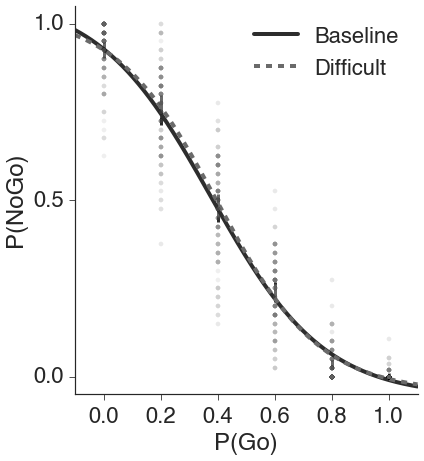

In [33]:
scurves([bsl_pstop.values, pnl_pstop.values], yerr=[bsl_pstop_err.values, pnl_pstop_err.values], colors=colors, labels=labels, task='pro', sxdata=[bsl_pstop_idx, pnl_pstop_idx])

#plt.savefig(out+"pro_sc.png", format='png', dpi=600)
#plt.savefig(out+"pro_sc.svg", rasterized=True, dpi=600)

In [31]:
psebsl=scurves(bsl_pstop_idx.values, pse_only=True, task='Pro')
psepnl=scurves(pnl_pstop_idx.values, pse_only=True, task='Pro')

In [32]:
print np.mean(psebsl)
print np.mean(psepnl)

print stats.sem(psebsl)*1.96
print stats.sem(psepnl)*1.96

0.454414129938
0.452208007686
0.0234574153156
0.0172946799635


In [36]:
def plot_re_bar(y, ysim=[], yerr=[], ysimerr=[], sxdata=None, colors=[], ylabel='RT (ms)', yylim=[550,580], save=False, savepath="./"):

      f, ax = plt.subplots(1, figsize=(5.5, 6.5))
      x=np.array([1,2]); xsim=np.array([1.1, 1.9]);

      if colors==[]:
            colors=['#4E4E8B', '#AD3333', "#074feb", "#f81447"]

      if sxdata is not None:
            offset=-.32
            for i, cond in enumerate(sxdata):
                  for idxdata in cond:
                        if i>0: offset=.32
                  ax.plot(x[i]+offset, idxdata, color=colors[i], marker='o', ms=4.5, linewidth=0, alpha=.35)
      if ysim!=[]:
            ax.errorbar(xsim, ysim, yerr=ysimerr, marker='o', mfc=None, ms=10, lw=3, color='k', ecolor='k', elinewidth=3)
            ax.plot(xsim[0], ysim[0], marker='o', color=colors[2], ms=14, label='Baseline')
            ax.plot(xsim[1], ysim[1], marker='o', color=colors[3], ms=14, label='Caution')

      ax.bar(x, y, width=.5, align='center', yerr=yerr, color=colors, error_kw=dict(elinewidth=3, ecolor='k'), alpha=.9)

      ax.set_ylabel(ylabel, fontsize=30)
      plt.setp(ax, xticks=x, xlim=(0.6, 2.4), ylim=yylim, yticks=yylim)
      ax.set_yticklabels(yylim, fontsize=30)
      ax.set_xticklabels(['Baseline', 'Caution'], fontsize=30)
      sns.despine(); plt.tight_layout()

      #if save:
      #	plt.savefig(savepath+"Figure2_re_rt_idxfits_graygreen.png", rasterized=True, dpi=600)
      #	plt.savefig(savepath+"Figure2_re_rt_idxfits_graygreen.svg", rasterized=True, dpi=600)

      return ax


In [40]:
means_pse=[np.mean(psebsl), np.mean(psepnl)]
pse_err=[stats.sem(psebsl)*1.96, stats.sem(psepnl)*1.96]
sxdata=[psebsl, psepnl]


means_pse=np.array([0.454414129938, 0.452208007686])
pse_err=np.array([0.0234574153156, 0.0172946799635])
ax=plot_re_bar(means_pse, yerr=pse_err, yylim=[.4, .5], ylabel='PSE', colors=colors)
plt.savefig(out+'pre_pse.png', dpi=900, format='png')
plt.savefig(out+'pro_pse.svg', dpi=900, format='svg')

## PSE

In [42]:
print "bsl/pnl PSE means: ", means_pse
print "t:%.4f\np:%.4f"% ttest_rel(sxdata[0], sxdata[1])

bsl/pnl PSE means:  [ 0.45441  0.45221]
t:0.2059
p:0.8376


In [43]:
bsl_rt_idx=bsl.query("response==1").pivot_table('rt', 'idx', 'pGo')
pnl_rt_idx=pnl.query("response==1").pivot_table('rt', 'idx', 'pGo')

bsl_rt=bsl_rt_idx.mean()
pnl_rt=pnl_rt_idx.mean()

bsl_rt_err=bsl_rt_idx.sem()*1.96
pnl_rt_err=pnl_rt_idx.sem()*1.96

In [51]:
x=np.array([20, 50, 80, 110, 140 ])
#pro_rt_mean=pro_rt.mean()[:-1]

f, ax = plt.subplots(1, figsize=(6.5,6.5))
ax.bar(x-10, bsl_rt.iloc[1:]*1000, yerr=bsl_rt_err.iloc[1:]*1000, color=colors[0], width=10, error_kw={"ecolor":'k', "capsize":0, 'elinewidth':3}, edgecolor=[colors[0]]*len(x), alpha=.9, label=labels[0])

x=np.array([20, 50, 80, 110, 140 ])
ax.bar(x+5, pnl_rt.iloc[1:]*1000, yerr=pnl_rt_err.iloc[1:]*1000, color=colors[1], width=10, align='center', error_kw={"ecolor":'k', "capsize":0, 'elinewidth':3}, edgecolor=[colors[0]]*len(x), alpha=.9, label=labels[1])

plt.setp(ax, ylim=[500, 560], xlim=[0, 160], xticks=x, yticks=[500, 560])

#for i, sx in enumerate(bsl_rt_idx.values):
#    ax.plot(x-12, sx[1:]*1000, linewidth=0, marker='o', ms=4, alpha=.2, color=colors[0])
    
#for i, sx in enumerate(pnl_rt_idx.values):
#    ax.plot(x+12, sx[1:]*1000, linewidth=0, marker='o', ms=4, alpha=.2, color=colors[1])

ax.set_xlabel('P(Go)', fontsize=25)
ax.set_ylabel('RT (ms)', fontsize=25)

ax.set_xticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=23)
ax.set_yticklabels([500, 560], fontsize=23)

ax.legend(loc=1, fontsize=23)
plt.tight_layout()
sns.despine()

plt.savefig(out+"pro_rt.png", format='png', dpi=900)
plt.savefig(out+"pro_rt.svg", format='svg', dpi=900)

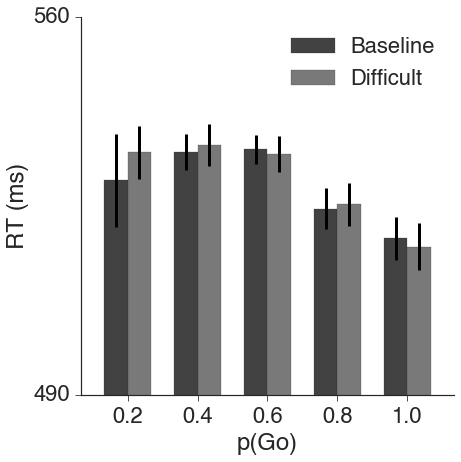

In [25]:
x=np.array([20, 50, 80, 110, 140 ])
#pro_rt_mean=pro_rt.mean()[:-1]

f, ax = plt.subplots(1, figsize=(6.5,6.5))
ax.bar(x-10, bsl_rt.iloc[1:]*1000, yerr=bsl_rt_err.iloc[1:]*1000, color=colors[0], width=10, error_kw={"ecolor":'k', "capsize":0}, edgecolor=[colors[0]]*len(x), alpha=.9, label=labels[0])

x=np.array([20, 50, 80, 110, 140 ])
ax.bar(x+5, pnl_rt.iloc[1:]*1000, yerr=pnl_rt_err.iloc[1:]*1000, color=colors[1], width=10, align='center', error_kw={"ecolor":'k', "capsize":0}, edgecolor=[colors[0]]*len(x), alpha=.9, label=labels[1])

plt.setp(ax, ylim=[490, 560], xlim=[0, 160], xticks=x, yticks=[490, 560])

#for i, sx in enumerate(bsl_rt_idx.values):
#    ax.plot(x-12, sx[1:]*1000, linewidth=0, marker='o', ms=4, alpha=.2, color=colors[0])
    
#for i, sx in enumerate(pnl_rt_idx.values):
#    ax.plot(x+12, sx[1:]*1000, linewidth=0, marker='o', ms=4, alpha=.2, color=colors[1])

ax.set_xlabel('P(Go)', fontsize=24)
ax.set_ylabel('RT (ms)', fontsize=24)

ax.set_xticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=22)
ax.set_yticklabels([490, 560], fontsize=22)

ax.legend(loc=1, fontsize=22)
plt.tight_layout()
sns.despine()

#plt.savefig(out+"pro_rt.png", format='png', dpi=600)
#plt.savefig("pro_rt_data.svg", rasterized=True, dpi=600)